# doNd together sweep and logging

This example notebook contains simple cases in which the `doNd` utilities of QCoDeS can be used to perform measurements. The `doNd` functions are generic wrappers of QCoDeS `Measurement` in zero, one, and two dimensions, as well as the general n dimension. To have a better picture of the difference between the two approaches, we compare `doNd` and `Measurement` side-by-side in some cases. In what follows, we shall provide the most basic functionalities and leave more detailed practices to the user. In particular, we shall not concern about single-point measurements.

## Setup before measurement

Here, we call necessary imports for running this notebook, as well as setting up a database, dummy parameters, and creating an experiment object.

In [1]:
import os
import time
import numpy as np
from qcodes.dataset import do1d, do2d, dond, LinSweep, LogSweep, ArraySweep, TogetherSweep
from qcodes.utils.dataset.doNd import plot
from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_dataset

In [2]:
tutorial_db_path = os.path.join(os.getcwd(), 'tutorial_doNd.db')
initialise_or_create_database_at(tutorial_db_path)

First, we set up two dummy instruments to have something to measure. The dmm is set up to generate output depending on the values set on the dac simulating a real experiment.

In [3]:
# preparatory mocking of physical setup
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)

We create an experiment for the purpose of this notebook.

In [4]:
tutorial_exp = load_or_create_experiment('doNd_VS_Measurement', sample_name='no sample')

## Generalized n-dimensional measurement (`dond`)

## Sweep multiple parameters in parallel

Sometimes it may be required to measure a parameter while sweeping two or more parameters at the same time. `dond` supports this by using the special construct `TogetherSweep` to take a list of sweeps to be performed at the same time and passing that to `dond`. Note that this required you to use sweeps of the same length for all components in a `TogetherSweep`. In the example below we measure as a function of both channels of the DAC.

In [5]:
sweep_1 = LinSweep(dac.ch1, -1, 1, 20, 0.01)
sweep_2 = LinSweep(dac.ch2, -1, 1, 20, 0.01)
together_sweep = TogetherSweep(sweep_1, sweep_2)

Starting experimental run with id: 236. Using 'qcodes.dataset.dond'


  0%|          | 0/20 [00:00<?, ?it/s]

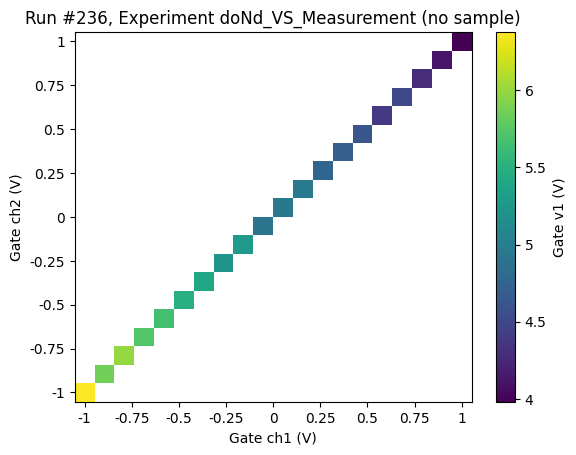

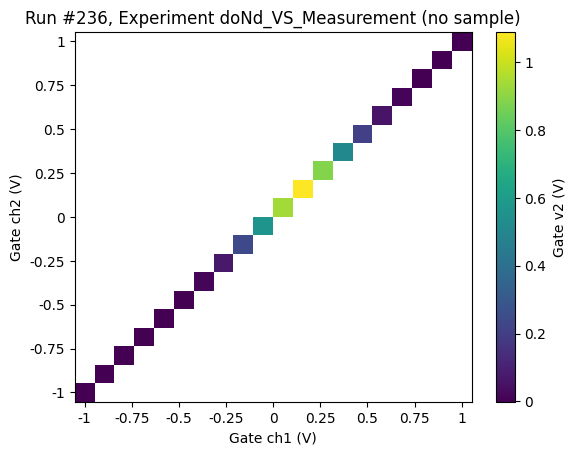

In [6]:
result = dond(together_sweep, dmm.v1, dmm.v2, do_plot=True, show_progress=True)

Note that by default this means that we will create one or more datasets where the dependent parameter depends on all the parameters in the `TogetherSweep` e.g. `Gate V2` depends on both `Gate ch1` and `Gate ch2` in the example above.

Sometimes this may not be what you want but rather you are performing two or more measurements independently and want the datasets to reflect this.
E.g. imagine that you are performing experiments on two different physical systems where you know that `dmm.v1` only depends on `dac.ch1` and `dmm.v2` only depends on `dac.ch2`. 
In these cases it is possible to use the argument `dataset_dependencies` to tell `do_nd` how the dependent parameters map to independent parameters as in the example below. Note that there is no way 
for QCoDeS to verify these dependencies are correct for your physical system and is is your responsibility to ensure that they are. 


Starting experimental run with id: 237. Using 'qcodes.dataset.dond'
Starting experimental run with id: 238. Using 'qcodes.dataset.dond'


  0%|          | 0/20 [00:00<?, ?it/s]

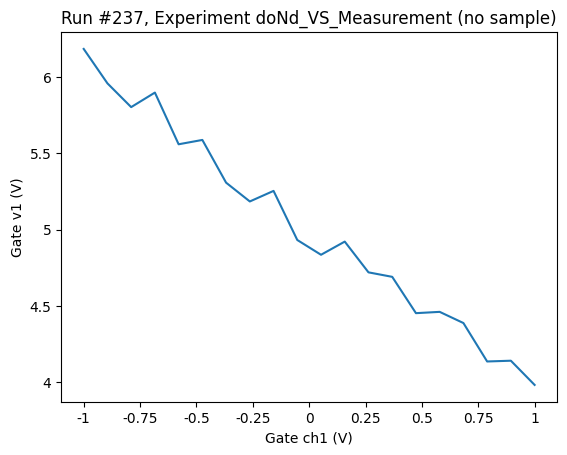

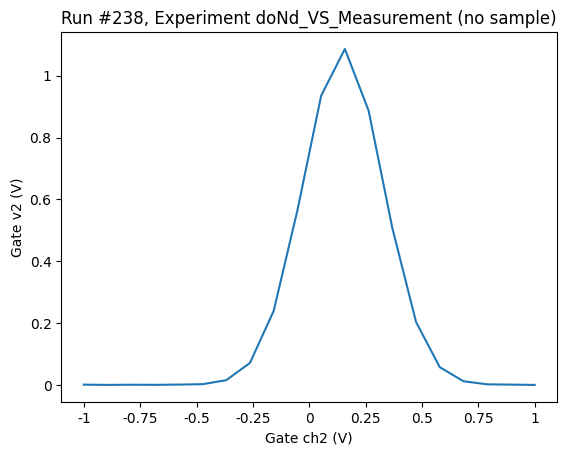

In [7]:
result = dond(
    together_sweep,
    dmm.v1,
    dmm.v2,
    do_plot=True,
    show_progress=True,
    dataset_dependencies={
        "ds1": (dac.ch1, dmm.v1), 
        "ds2": (dac.ch2, dmm.v2),
    }
)

## Using logging to debug your measurement

In [9]:
from qcodes.logger import console_level,start_logger, filter_instrument
import logging
start_logger()

Qcodes Logfile : C:\Users\jenielse\.qcodes\logs\221005-5804-qcodes.log


2022-10-05 15:56:12,275 ¦ qcodes.dataset.dond.do_nd ¦ DEBUG ¦ do_nd ¦ _get_shapes ¦ 369 ¦ Detected shapes to be {'dmm_v1': (20,), 'dmm_v2': (20,)}
2022-10-05 15:56:12,277 ¦ qcodes.dataset.measurements ¦ INFO ¦ measurements ¦ _register_parameter ¦ 964 ¦ Registered dac_ch1 in the Measurement.
2022-10-05 15:56:12,279 ¦ qcodes.dataset.measurements ¦ INFO ¦ measurements ¦ _register_parameter ¦ 964 ¦ Registered dac_ch2 in the Measurement.
2022-10-05 15:56:12,281 ¦ qcodes.dataset.measurements ¦ INFO ¦ measurements ¦ _register_parameter ¦ 964 ¦ Registered dmm_v1 in the Measurement.
2022-10-05 15:56:12,284 ¦ qcodes.dataset.measurements ¦ INFO ¦ measurements ¦ _register_parameter ¦ 964 ¦ Registered dmm_v2 in the Measurement.
2022-10-05 15:56:12,285 ¦ qcodes.dataset.dond.do_nd ¦ INFO ¦ do_nd ¦ dond ¦ 663 ¦ Starting a doNd with scan with
 setpoints: (<qcodes.parameters.parameter.Parameter: ch1 at 2026980753520>, <qcodes.parameters.parameter.Parameter: ch2 at 2025670906784>),
 measuring: (<qcodes.t

Starting experimental run with id: 239. Using 'qcodes.dataset.dond'


  0%|          | 0/20 [00:00<?, ?it/s]

2022-10-05 15:56:13,036 ¦ qcodes.dataset.data_set ¦ DEBUG ¦ data_set ¦ _flush_data_to_database ¦ 1403 ¦ Flushing to database
2022-10-05 15:56:13,049 ¦ qcodes.dataset.data_set ¦ DEBUG ¦ data_set ¦ _flush_data_to_database ¦ 1412 ¦ Successfully wrote result to disk
2022-10-05 15:56:13,055 ¦ qcodes.dataset.measurements ¦ INFO ¦ measurements ¦ __exit__ ¦ 676 ¦ Finished measurement with guid: aaaaaaaa-0000-0000-0000-0183a86eb98c. Using 'qcodes.dataset.dond'
2022-10-05 15:56:13,105 ¦ qcodes.dataset.plotting ¦ DEBUG ¦ plotting ¦ plot_dataset ¦ 260 ¦ Doing a 2D plot with kwargs: {}
2022-10-05 15:56:13,107 ¦ qcodes.dataset.plotting ¦ DEBUG ¦ plotting ¦ plot_on_a_plain_grid ¦ 610 ¦ Got kwargs: {'cmap': 'viridis'}
2022-10-05 15:56:13,108 ¦ qcodes.dataset.data_export ¦ DEBUG ¦ data_export ¦ reshape_2D_data ¦ 397 ¦ Sorting 2D data onto grid
2022-10-05 15:56:13,136 ¦ matplotlib.colorbar ¦ DEBUG ¦ colorbar ¦ _get_ticker_locator_formatter ¦ 850 ¦ locator: <matplotlib.ticker.AutoLocator object at 0x0000

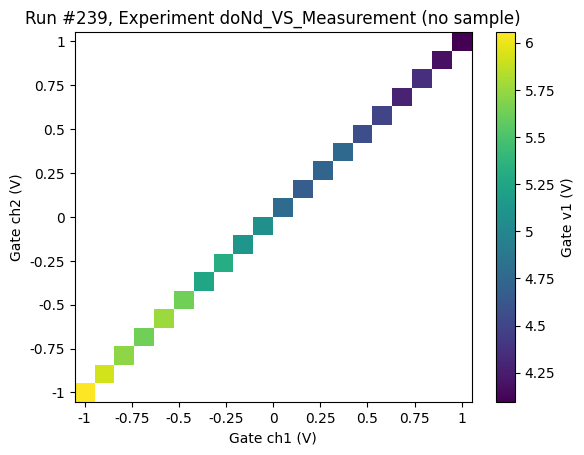

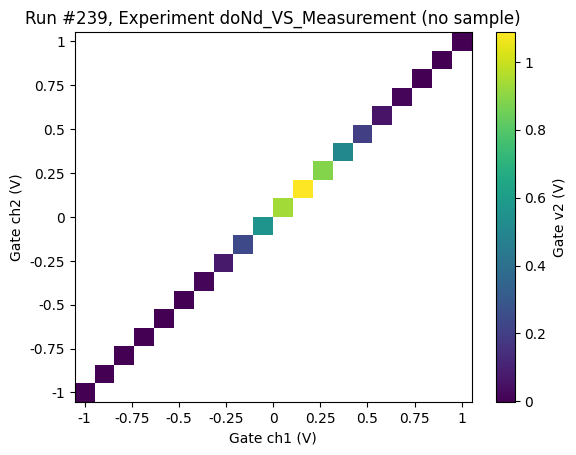

In [10]:
with console_level(logging.DEBUG):
    result = dond(together_sweep, dmm.v1, dmm.v2, do_plot=True, show_progress=True)

In [11]:

from qcodes.instrument_drivers.american_magnetics import AMIModel4303D, AMIModel430

import qcodes.instrument.sims as sims

visalib = sims.__file__.replace('__init__.py', 'AMI430.yaml@sim')

mag_x = AMIModel430('x', address='GPIB::1::INSTR', visalib=visalib,
                        terminator='\n')
mag_y = AMIModel430('y', address='GPIB::2::INSTR', visalib=visalib,
                        terminator='\n')
mag_z = AMIModel430('z', address='GPIB::3::INSTR', visalib=visalib,
                        terminator='\n')

import numpy as np
field_limit = [
    lambda x, y, z: x == 0 and y == 0 and z < 3,
    lambda x, y, z: np.linalg.norm([x, y, z]) < 2
]

driver = AMIModel4303D("AMI430_3D", mag_x, mag_y, mag_z, field_limit)

Connected to: QCoDeS AMI430_simulation (serial:1337, firmware:0.0.01) in 0.04s
Connected to: QCoDeS AMI430_simulation (serial:1337, firmware:0.0.01) in 0.00s
Connected to: QCoDeS AMI430_simulation (serial:1337, firmware:0.0.01) in 0.00s


In [12]:
driver.cartesian((0, 0, 0))
with console_level('DEBUG'):
    with filter_instrument(mag_x):
        driver.cartesian((0, 0, 1))
        
        driver.cartesian((1,0,0))

2022-10-05 15:56:24,557 ¦ qcodes.instrument.instrument_base.com.visa ¦ DEBUG ¦ visa ¦ ask_raw ¦ 219 ¦ [x(AMIModel430)] Querying: STATE?
2022-10-05 15:56:24,558 ¦ qcodes.instrument.instrument_base.com.visa ¦ DEBUG ¦ visa ¦ ask_raw ¦ 221 ¦ [x(AMIModel430)] Response: 2
2022-10-05 15:56:24,560 ¦ qcodes.instrument.instrument_base.com.visa ¦ DEBUG ¦ visa ¦ ask_raw ¦ 219 ¦ [x(AMIModel430)] Querying: FIELD:MAG?
2022-10-05 15:56:24,562 ¦ qcodes.instrument.instrument_base.com.visa ¦ DEBUG ¦ visa ¦ ask_raw ¦ 221 ¦ [x(AMIModel430)] Response: 0.0
2022-10-05 15:56:24,564 ¦ qcodes.instrument.instrument_base.com.visa ¦ DEBUG ¦ visa ¦ ask_raw ¦ 219 ¦ [x(AMIModel430)] Querying: FIELD:MAG?
2022-10-05 15:56:24,565 ¦ qcodes.instrument.instrument_base.com.visa ¦ DEBUG ¦ visa ¦ ask_raw ¦ 221 ¦ [x(AMIModel430)] Response: 0.0
2022-10-05 15:56:24,568 ¦ qcodes.instrument.instrument_base.com.visa ¦ DEBUG ¦ visa ¦ ask_raw ¦ 219 ¦ [x(AMIModel430)] Querying: STATE?
2022-10-05 15:56:24,569 ¦ qcodes.instrument.instrum